In [1]:
from FwtModels import AssumedShapes
import numpy as np
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import y,x,t
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from scipy.linalg import eig

plt.style.use('seaborn')

# Create Model of the WT model using Assumed Shapes

Want to create a model of the wing using in the WT tests (flexible wing with a FWT) using assumed shapes, within this notebook we:
1. Define the WT Model parameters
2. Look at the free vibrations of the fixed hinge case (modeling FWT as both flexible and rigid)
3. Aeroelastic behaviour of this wing
4. Look at the free vibrations of the free hinge case (with spring stiffness)
5. Aeroelastic behaviour of the fwt

    ## Model Definition

Will use parameter from the wing used in the WTT's in December, it had a span of 1.345m and the structural properties closely match those of the steel beam at its quarter-cord (5mm x 30mm cross section, 310L stainless steel). Assume a uniform mass distribution and a total weight of 2.75Kg. (the FWT took up 29% of the wetted area, but for now we are modelling as a continous beam)

In [2]:
semiSpan = 1.345  # semi-span of the wing
ratioFwt = 0   # ratio of the wing semi span that is fwt
wingMass = 2.75   # mass of entire semi-span wing
chord = 0.15

mu = wingMass/(chord*semiSpan) # mass density of the wing

modeling the structural properties of a rectangular bar

In [3]:
# with width b and hieght h
h = 0.005 # hieght of bar
b = 0.03 # width of bar
I_xx = b*h**3/12
I_yy = b**3*h/12
J = I_xx + I_yy

# Material properties
E = 190e9
G = 74e9

In [4]:
# create an instance of the class holding all the properties for the FWT
p = AssumedShapes.FwtParameters(m_w = mu,
                        m_t = mu,
                        x_f = 0.25,
                        s_w = semiSpan*(1-ratioFwt),
                        s_t = semiSpan*ratioFwt,
                        c = chord,
                        Lambda = np.deg2rad(10),
                        EI = E*I_xx,
                        GJ = G*J,
                        k_theta = 0,
                        rho = 1.225,
                        V = 10,
                        a_w = 2*np.pi,
                        a_t = 2*np.pi,
                        alpha_0 = 0,
                        e = 0,
                        Malphadot = -1.2,
                        g = 9.81)

## Free Vibrations of the Fixed Hinge Case

### Consider Only z Bending with Multiple Shapes

As noted in jonathan's book the natural frequency of a sDof contious beam is given by:

$\omega=3.516 \sqrt{\frac{E I}{\mu s^{4}}}$

this answer should approximate well the frequency of the first bending moment of this wing

Find the natural frequency and mode shapes using multiple shapes

In [8]:
f = 3.516*np.sqrt(E*I_xx/(mu*chord*semiSpan**4))
print(f'Natural Frequency: {f:.2f} Hz')

Natural Frequency: 10.47 Hz


Hence if we find the natural frequency of the beam using assumed shapes the 1st frequecny should approach this value

In [15]:
# create generalised coordinates
q0,q1,q2,q3 = me.dynamicsymbols('q:4') 
q = sym.Matrix([q0,q1,q2,q3])

# created assumed shapes for ever higher order models then create a numerical model and find the minimium modal frequency
Data = pd.DataFrame()
for i in np.arange(0,len(q)):
    # define shape Functions
    z_w = sym.Rational(0,1)
    for j in np.arange(0,i+1):
        z_w = z_w + q[j]*y**(2+j)

    alpha_w = sym.Rational(0,1)

    # FWT is locked so is parrallel to the end of the main wing
    z_t = z_w.subs(y,p.s_w) + z_w.diff(y).subs(y,p.s_w)*y
    alpha_t = alpha_w.subs(y,p.s_w)

    # create the model
    sModel = AssumedShapes.SymbolicModel(q,z_w,alpha_w,z_t,alpha_t,p)
    sModel.GenerateEoM()
    
    # create numeric Model
    nModel = sModel.createNumericInstance()
    
    # Get Eigen values and vectors
    df = nModel.FreeVibrationValsPd()
    df['Mode'] = df.index
    df['Shapes'] = i+1
    df = df.set_index('Shapes')
    Data = pd.concat([Data,df],axis =0)

In [16]:
# Show only the first mode for each shape
Data[Data['Mode']==0]

,Freq,Comp 0,Comp 1,Comp 2,Comp 3,Mode
Shapes,,,,,,
1,13.321927,1.000000,0.000000,0.000000,0.000000,0
2,10.523560,-0.961641,0.274312,-0.000000,-0.000000,0
3,10.476924,0.924234,-0.378189,0.052582,-0.000000,0
4,10.473780,-0.950127,0.309405,0.029685,-0.025418,0


this confirms the same as before ( although with non-unity numbers) the the model tends to the exact answer. Albeit I was expecting this frequency to be a lot lower (<2Hz), which needs to be investigated

#### Plot the mode shape of the lowest frequency mode for each model

As an example of the mode shapes lets plot the mode shape of the first mode here. First we need to create a function to convert each row in this data table into a mode shape in y

In [17]:
# define a function to convert the data frame above into mode shapes
def ModeShapePd(y,df):
    ySpanDf = pd.DataFrame()
    ySpanDf['y'] = y
    ySpanDf = ySpanDf.set_index('y')
    
    comps =[]   
    for i in range(0,4):
        comps.append(f'Comp {i}')
    compsDf = df[comps]
    
    for i in range(0,len(df.index)):
        valsAr = compsDf.iloc[i].to_numpy()
        vals = tuple(valsAr)
        f = df['Freq'].iloc[i]
        s = f'Shapes {df.index[i]}, Freq {f:.2f}'
        ySpanDf = sModel.Zpd(vals,0.15*0.25,ySpanDf,s)
    return ySpanDf

Now we can plot the first 4 mode shapes using

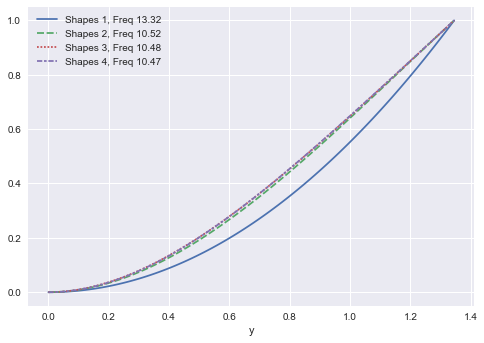

In [18]:
d = ModeShapePd(np.linspace(0,1.345,100),Data[Data['Mode']==0])
sns.lineplot(data = d / d.max())

the shape of the lowest mode has changed significantly for the 4 shapes varient.

Plotting the 4 mode shapes for that model looks like the following:

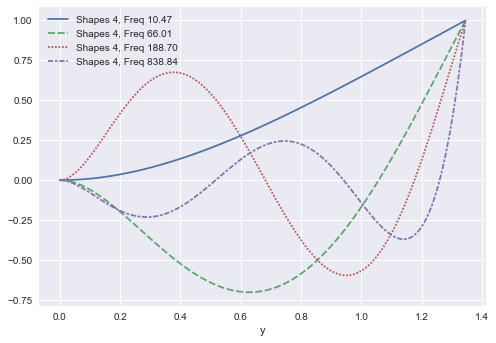

In [19]:
d = ModeShapePd(np.linspace(0,1.345,100),Data[Data.index==4])
sns.lineplot(data = d / d.max())

In [20]:
eig(nModel.K,nModel.M)

(array([7.03651828e+05+0.j, 3.56082369e+04+0.j, 4.35670930e+03+0.j,
        1.09700073e+02+0.j]),
 array([[-0.16272816,  0.24243199, -0.49905693, -0.95012703],
        [ 0.61721654, -0.70712759,  0.79307701,  0.30940482],
        [-0.7223896 ,  0.63904684, -0.34684109,  0.02968488],
        [ 0.26592586, -0.18115305,  0.04089367, -0.02541831]]))

The higher frequency modes seem to have taken the shape of low frequency one?

## Calculating the Complex modal frequencies 'By Hand'

Will run through the generation of the complex modal frequencies and eigenvectors by hand to check what the answers should be, then will reproduce this values with the in-built function in the package

Going back to the simple 1 Assumed shape, lets added the aero force matrices and see the effect to the frequencies


In [31]:
sModel = AssumedShapes.SymbolicModel.B1_T0_RLFwt(p)
sModel.GenerateEoM()

Create the Mprime and Vprime matrices by hand to solve the flutter eigen value problem, as described in section 11.4 of Jonathans book

$\left[\begin{array}{cc}{\mathbf{I}} & {\mathbf{0}} \\ {\mathbf{0}} & {\mathbf{A}}\end{array}\right]\left\{\begin{array}{l}{\dot{q}} \\ {\ddot{q}}\end{array}\right\}-\left[\begin{array}{cc}{\mathbf{0}} & {\mathbf{I}} \\ {-\left(\rho V^{2} \mathbf{C}+\mathbf{E}\right)} & {-(\rho V \mathbf{B}+\mathbf{D})}\end{array}\right]\left\{\begin{array}{l}{q} \\ {\dot{q}}\end{array}\right\}=\left\{\begin{array}{l}{0} \\ {0}\end{array}\right\}$

And then generate the Q matrix as shown below

$\left\{\begin{array}{l}{\dot{q}} \\ {\ddot{q}}\end{array}\right\}-\left[\begin{array}{cc}{0} & {\mathrm{I}} \\ {-\mathrm{A}^{-1}\left(\rho V^{2} \mathbf{C}+\mathbf{E}\right)} & {-\mathbf{A}^{-1}(\rho V \mathbf{B}+\mathbf{D})}\end{array}\right]\left\{\begin{array}{l}{q} \\ {\dot{q}}\end{array}\right\}=0,    \dot{x}-\mathbf{Q} x=0$

Note there is a differnce between what I've done and this so I'm creating

$\left\{\begin{array}{l}{\dot{q}} \\ {\ddot{q}}\end{array}\right\}-\left[\begin{array}{cc}{0} & {\mathrm{I}} \\ {-\mathrm{A}^{-1}\left(-\rho V^{2} \mathbf{C}+\mathbf{E}\right)} & {\mathbf{A}^{-1}(\rho V \mathbf{B}-\mathbf{D})}\end{array}\right]\left\{\begin{array}{l}{q} \\ {\dot{q}}\end{array}\right\}=0,    \dot{x}-\mathbf{Q} x=0$

In [32]:
mPrime = sym.eye(2)
mPrime[1,1] = sModel.M.subs(p.s_t,0)
mPrime

⎡1      0     ⎤
⎢             ⎥
⎢            5⎥
⎢   c⋅m_w⋅s_w ⎥
⎢0  ──────────⎥
⎣       5     ⎦

In [33]:
kPrime = sym.zeros(2)
kPrime[0,1] = 1
kPrime[1,0] = -(sModel.C + sModel.K)
kPrime[1,1] = sModel.B.subs(p.s_t,0) # D is zero is this case (no structural damping)

kPrime

⎡    0             1        ⎤
⎢                           ⎥
⎢                         5 ⎥
⎢           -V⋅a_w⋅c⋅ρ⋅s_w  ⎥
⎢-4⋅EI⋅s_w  ────────────────⎥
⎣                  10       ⎦

In [34]:
Q = mPrime**-1*kPrime
Q

⎡    0           1    ⎤
⎢                     ⎥
⎢ -20⋅EI     -V⋅a_w⋅ρ ⎥
⎢──────────  ─────────⎥
⎢         4    2⋅m_w  ⎥
⎣c⋅m_w⋅s_w            ⎦

Get the Eigenvalues of this matrix

In [35]:
vals = sym.Matrix(list(Q.eigenvals().keys()))
vals

⎡               _____________________________________⎤
⎢              ╱   ⎛               2    2    2    4⎞ ⎥
⎢  V⋅a_w⋅ρ   ╲╱  c⋅⎝-320⋅EI⋅m_w + V ⋅a_w ⋅c⋅ρ ⋅s_w ⎠ ⎥
⎢- ─────── - ────────────────────────────────────────⎥
⎢   4⋅m_w                             2              ⎥
⎢                          4⋅c⋅m_w⋅s_w               ⎥
⎢                                                    ⎥
⎢               _____________________________________⎥
⎢              ╱   ⎛               2    2    2    4⎞ ⎥
⎢  V⋅a_w⋅ρ   ╲╱  c⋅⎝-320⋅EI⋅m_w + V ⋅a_w ⋅c⋅ρ ⋅s_w ⎠ ⎥
⎢- ─────── + ────────────────────────────────────────⎥
⎢   4⋅m_w                             2              ⎥
⎣                          4⋅c⋅m_w⋅s_w               ⎦

sub it all in except velocity

In [36]:
subs = dict((s,s.value) for s in p.GetTuple())
subs.pop(p.V,None) # remove V from dict
Vvals = vals.subs(subs)
Vvals[1]

We have imaginary components! Lets get values for many V's and see if I can get frequency and dampings

Although these will never have a negative real component?

In [37]:
f2 = sym.lambdify(p.V,Vvals,[{'sqrt':np.lib.scimath.sqrt},'numpy'])
f2(2)

array([[-0.28233636-13.31893441j],
       [-0.28233636+13.31893441j]])

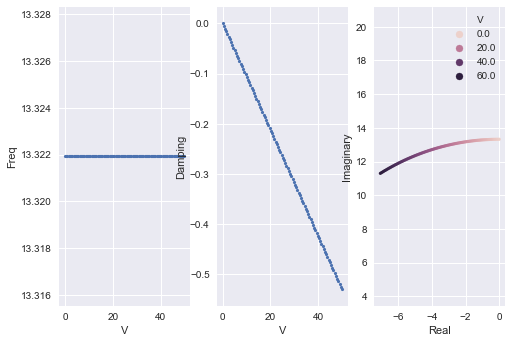

In [48]:
# lets plot how freq and damping vary with velocity
v = np.linspace(0,50,100)

f = sym.lambdify(p.V,Vvals[1],[{'sqrt':np.lib.scimath.sqrt},'numpy'])

vDf = pd.DataFrame(data=v,columns=['V'])

def getFD(data):
    mode = f(data['V'])
    r = np.real(mode)
    i = np.abs(np.abs(np.imag(mode)))
    if i>0:
        om = np.sqrt(i**2+np.abs(r)**2)
        dam = r/om
    else:
        om = 0
        dam = r
    return pd.Series([r,i,om,dam])

vDf[['Real','Imaginary','Freq','Damping']] = vDf.apply(getFD,axis=1)

f, axes = plt.subplots(1, 3)
sns.scatterplot(data = vDf, x='V',y='Freq',ax=axes[0],s=10,linewidth=0)
sns.scatterplot(data = vDf, x='V',y='Damping',ax=axes[1],s=10,linewidth=0)
sns.scatterplot(data = vDf, x='Real',y='Imaginary',hue='V',ax=axes[2],s=10,linewidth=0)
axes[2].axis('equal')
plt.show()

So with a single mode there is no posibility of flutter as the as modes cannot interact, you can get divergence though...

The divergence speed is when the freq goes and the real part of the eigen value is also zero, which happens >300m/s this may be the limit of this assumed shapes usefullness?

Its a single DoF sytem what do I actually expect???


### Compare the result of the symbolic model to that of the numeric model

In [45]:
nModel = sModel.createNumericInstance()

In [46]:
mode = nModel.AeroVibrations()[0][0]
print(f'Freq = {np.abs(mode)}, Damping = {np.cos(np.angle(mode))}')


Freq = 13.3219265765784, Damping = -0.10596679022055171


seems good to me!